In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
df=pd.read_csv("layoffs.csv")
df

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,The Good Glamm Group,New Delhi,Retail,150.00,0.15,2024-04-18,Unknown,India,180.00
1,Stability AI,London,AI,20.00,NaN,2024-04-18,Unknown,United Kingdom,174.00
2,ConnectWise,Tampa Bay,Other,NaN,NaN,2024-04-17,Acquired,United States,1.00
3,Google,SF Bay Area,Consumer,NaN,NaN,2024-04-17,Post-IPO,United States,26.00
4,Rivian,Detroit,Transportation,NaN,0.01,2024-04-17,Post-IPO,United States,10700.00
...,...,...,...,...,...,...,...,...,...
3563,Service,Los Angeles,Travel,NaN,1.00,2020-03-16,Seed,United States,5.10
3564,HopSkipDrive,Los Angeles,Transportation,8.00,0.10,2020-03-13,Unknown,United States,45.00
3565,Panda Squad,SF Bay Area,Consumer,6.00,0.75,2020-03-13,Seed,United States,1.00
3566,Tamara Mellon,Los Angeles,Retail,20.00,0.40,2020-03-12,Series C,United States,90.00


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [ ]:
# Getting all the columns of a dataset
df.columns

Index(['company', 'location', 'industry', 'total_laid_off',
       'percentage_laid_off', 'date', 'stage', 'country', 'funds_raised',
       'month', 'year'],
      dtype='object')

In [ ]:
# Fetching basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3568 entries, 0 to 3567
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   company              3568 non-null   object        
 1   location             3567 non-null   object        
 2   industry             3567 non-null   object        
 3   total_laid_off       2338 non-null   float64       
 4   percentage_laid_off  2295 non-null   float64       
 5   date                 3568 non-null   datetime64[ns]
 6   stage                3561 non-null   object        
 7   country              3568 non-null   object        
 8   funds_raised         3186 non-null   float64       
 9   month                3568 non-null   int32         
 10  year                 3568 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(2), object(5)
memory usage: 278.9+ KB


In [ ]:
# Fetching the duplicated row count in the dataset
df.duplicated().sum()

# Dropping off the duplicates values from dataset
df.drop_duplicates(inplace = True)

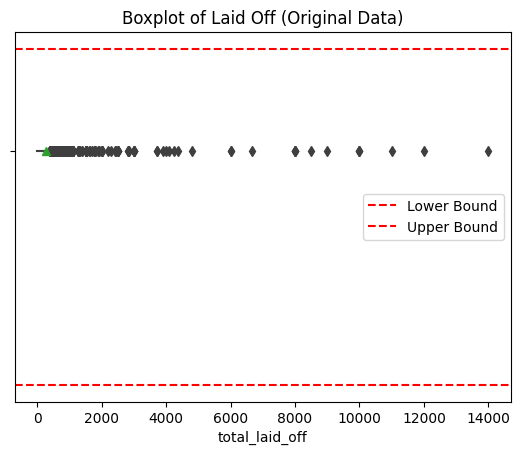

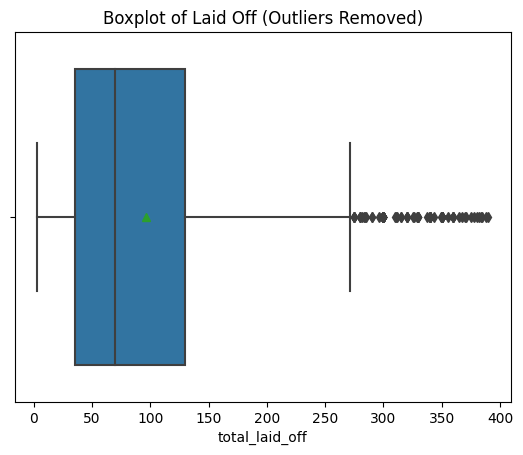



Number of rows removed as outliers: 1500


In [ ]:
def detect_outliers_iqr(df, column_name):
  q1 = df[column_name].quantile(0.25)
  q3 = df[column_name].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr)
  return iqr, lower_bound, upper_bound

# Detect outliers
iqr, lower_bound, upper_bound = detect_outliers_iqr(df.copy(), 'total_laid_off')

# Create a boxplot to visualize outliers (original data)
sns.boxplot(
    x = "total_laid_off",
    showmeans=True,
    data=df
)
plt.title("Boxplot of Laid Off (Original Data)")
plt.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='red', linestyle='--', label='Upper Bound')
plt.legend()
plt.show()

# Remove outliers
filtered_df = df.query('total_laid_off >= @lower_bound and total_laid_off <= @upper_bound')

# Create a boxplot to visualize outliers (after removing outliers)
sns.boxplot(
    x = "total_laid_off",
    showmeans=True,
    data=filtered_df
)
plt.title("Boxplot of Laid Off (Outliers Removed)")
plt.show()

# Count removed rows (outliers)
num_outliers_removed = len(df) - len(filtered_df)
print("\n")
print(f"Number of rows removed as outliers: {num_outliers_removed}")
df=filtered_df;


In [ ]:
# Count missing values in each column
missing_values = df.isnull().sum()

# Print missing values count for each column
print("Missing Values Count:")
print(missing_values)

Missing Values Count:
company                0
location               0
industry               0
total_laid_off         0
percentage_laid_off    0
date                   0
stage                  0
country                0
funds_raised           0
month                  0
year                   0
dtype: int64


In [ ]:
# Impute missing values for numeric columns with mean
numeric_columns = ['total_laid_off', 'percentage_laid_off', 'funds_raised']
for column in numeric_columns:
    df[column].fillna(df[column].mean(), inplace=True)

# Impute missing values for categorical columns with mode
categorical_columns = ['location', 'industry', 'stage']
for column in categorical_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [ ]:
# Select the numerical columns for analysis
numerical_columns = ['total_laid_off', 'percentage_laid_off', 'funds_raised']

# Calculate descriptive statistics for the numerical columns
descriptive_stats = df[numerical_columns].describe()

# Print the descriptive statistics
print(descriptive_stats)

       total_laid_off  percentage_laid_off  funds_raised
count         2066.00              1429.00       1881.00
mean            96.41                 0.22        768.38
std             83.64                 0.21       5824.20
min              3.00                 0.00          0.00
25%             35.00                 0.10         55.00
50%             70.00                 0.15        165.00
75%            130.00                 0.28        438.00
max            390.00                 1.00     121900.00


In [ ]:
# Fetching the necessary columns for correlation matrix
df1 = df.copy()
df1 = df1.select_dtypes(exclude = ["object"])

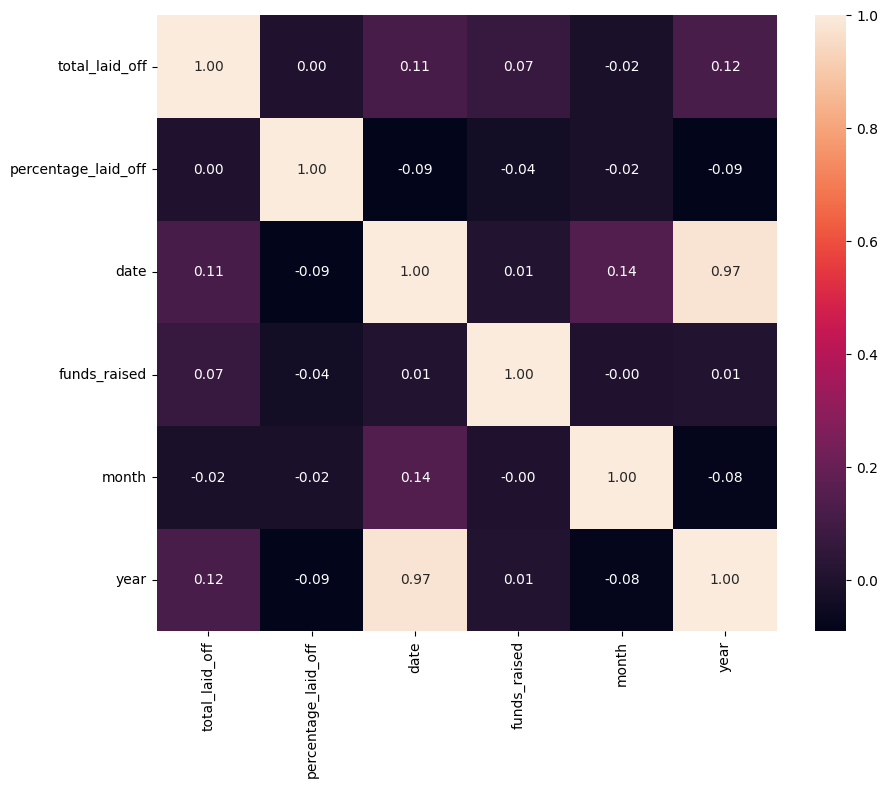

the encoded Dataset:

      total_laid_off  percentage_laid_off       date  funds_raised  month  \
0             150.00                 0.15 2024-04-18        180.00      4   
1              20.00                 0.22 2024-04-18        174.00      4   
6              12.00                 0.25 2024-04-16         75.00      4   
8             140.00                 0.04 2024-04-12         61.00      4   
9              25.00                 0.22 2024-04-12       1200.00      4   
...              ...                  ...        ...           ...    ...   
3562           16.00                 1.00 2020-03-16          6.00      3   
3564            8.00                 0.10 2020-03-13         45.00      3   
3565            6.00                 0.75 2020-03-13          1.00      3   
3566           20.00                 0.40 2020-03-12         90.00      3   
3567           75.00                 0.22 2020-03-11         12.00      3   

      year  
0     2024  
1     2024  
6     2024  
8

In [ ]:
# Create a heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df1.corr(), annot=True, fmt=".2f")
plt.show()
print("the encoded Dataset:\n")
print(df1)

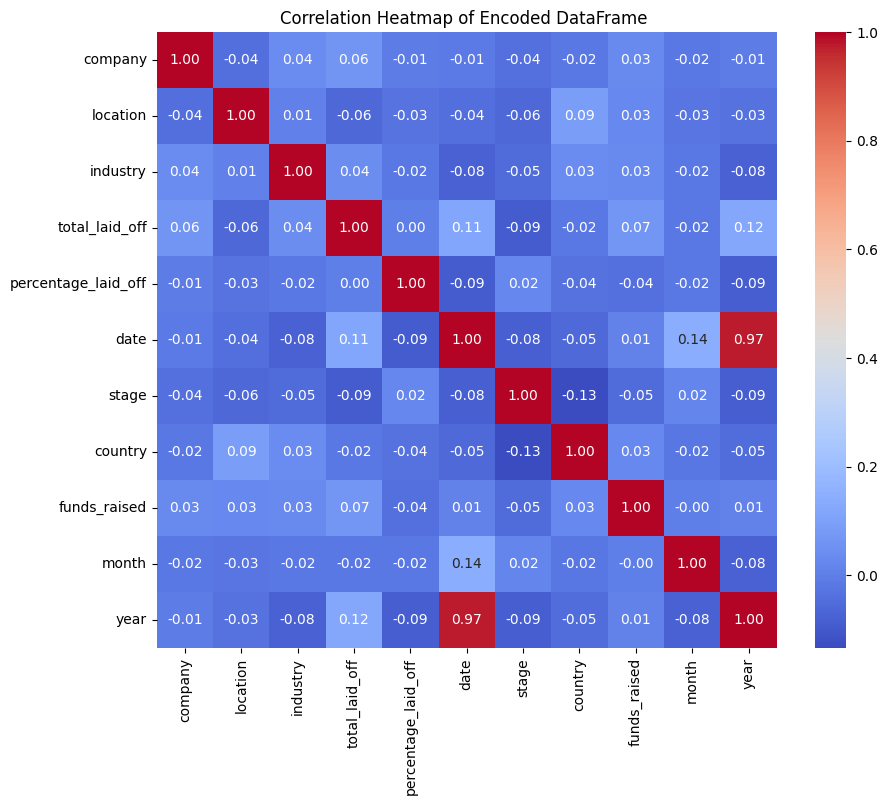

the encoded Dataset:

      company  location  industry  total_laid_off  percentage_laid_off  \
0        1377       115        24          150.00                 0.15   
1        1290        93         0           20.00                 0.22   
6        1414       133         0           12.00                 0.25   
8         350       122        18          140.00                 0.04   
9         573         9        10           25.00                 0.22   
...       ...       ...       ...             ...                  ...   
3562      626         6        27           16.00                 1.00   
3564      647        94        28            8.00                 0.10   
3565     1000       133         3            6.00                 0.75   
3566     1355        94        24           20.00                 0.40   
3567      433       135        16           75.00                 0.22   

           date  stage  country  funds_raised  month  year  
0    2024-04-18     15      

In [ ]:
# Assuming df is your original DataFrame
df2 = df.copy()


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column
df2['company'] = label_encoder.fit_transform(df2['company'])
df2['location'] = label_encoder.fit_transform(df2['location'])
df2['country'] = label_encoder.fit_transform(df2['country'])
df2['industry'] = label_encoder.fit_transform(df2['industry'])
df2['stage'] = label_encoder.fit_transform(df2['stage'])

# Create a heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df2.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap of Encoded DataFrame ')
plt.show()
print("the encoded Dataset:\n")
print(df2)

In [ ]:
from scipy.stats import chi2_contingency

df_main=df.copy()# Define the categorical features and the target variable
categorical_features = ['company', 'location', 'industry', 'percentage_laid_off', 'date', 'stage', 'country', 'funds_raised', 'month', 'year']
target_variable = 'total_laid_off'

# Create an empty dictionary to store chi-square statistics and p-values
chi2_results = {}

# Iterate over each categorical feature and calculate chi-squared statistic
for feature in categorical_features:
    # Create a contingency table between the feature and the target variable
    contingency_table = pd.crosstab(df_main[feature], df_main[target_variable])

    # Calculate the chi-squared statistic, p-value, degrees of freedom, and expected frequencies
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

    # Store the chi-squared statistic and p-value in the dictionary
    chi2_results[feature] = {'chi2_stat': chi2_stat, 'p_val': p_val}

# Print the chi-squared statistics and p-values
for feature, values in chi2_results.items():
    print(f"Feature: {feature}, Chi-squared Statistic: {values['chi2_stat']}, p-value: {values['p_val']}")
    print("\n")


Feature: company, Chi-squared Statistic: 364094.25732353, p-value: 1.0


Feature: location, Chi-squared Statistic: 38521.703151797534, p-value: 1.0


Feature: industry, Chi-squared Statistic: 7239.52880532901, p-value: 0.03171608546200504


Feature: percentage_laid_off, Chi-squared Statistic: 25637.909710365384, p-value: 3.828734034370296e-305


Feature: date, Chi-squared Statistic: 150181.46501759745, p-value: 1.0


Feature: stage, Chi-squared Statistic: 4149.797009986691, p-value: 2.622814575882263e-09


Feature: country, Chi-squared Statistic: 8289.66308038285, p-value: 1.0


Feature: funds_raised, Chi-squared Statistic: 153482.5683330228, p-value: 3.4719667953474617e-38


Feature: month, Chi-squared Statistic: 2774.3478992079517, p-value: 0.06329389957579751


Feature: year, Chi-squared Statistic: 1049.1516058908335, p-value: 0.035128818875762725




In [ ]:
df_main1=df.copy()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Define the features and the target variable
features = ['company', 'location', 'industry', 'percentage_laid_off', 'date', 'stage', 'country', 'funds_raised', 'month', 'year']
target_variable = 'total_laid_off'

encoder = OneHotEncoder(handle_unknown='ignore')
encoded_features = encoder.fit_transform(df_main1[features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_features, df_main1[target_variable], test_size=0.2, random_state=42)

# Initialize an empty list to store selected features
selected_features = []

# Initialize the best accuracy
best_accuracy = 0

# Perform forward selection
for feature in features:
    # Add the feature to the selected features list
    selected_features.append(feature)

    # Train a model using the selected features
    model = LogisticRegression()  # You can use any other classifier as well
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print the accuracy for the current feature set
    print("Selected Features:", selected_features)
    print("Accuracy:", accuracy)

    # Check if the current feature set improves the accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = selected_features.copy()
    else:
        # If adding the feature does not improve accuracy, remove it from the selected features list
        selected_features.remove(feature)

print("Best Features:", best_features)
print("Best Accuracy:", best_accuracy)


Selected Features: ['company']
Accuracy: 0.0821256038647343
Selected Features: ['company', 'location']
Accuracy: 0.0821256038647343
Selected Features: ['company', 'industry']
Accuracy: 0.0821256038647343
Selected Features: ['company', 'percentage_laid_off']
Accuracy: 0.0821256038647343
Selected Features: ['company', 'date']
Accuracy: 0.0821256038647343
Selected Features: ['company', 'stage']
Accuracy: 0.0821256038647343
Selected Features: ['company', 'country']
Accuracy: 0.0821256038647343
Selected Features: ['company', 'funds_raised']
Accuracy: 0.0821256038647343
Selected Features: ['company', 'month']
Accuracy: 0.0821256038647343
Selected Features: ['company', 'year']
Accuracy: 0.0821256038647343
Best Features: ['company']
Best Accuracy: 0.0821256038647343


In [ ]:
df3 = df.copy()
df3.index = df3.index.astype(str)
df3 = df3.set_index('date')
df_2024 = df3.loc[:'2024']
df_2023 = df3.loc[(df3.index > '2023-01-01')&(df3.index < '2024-01-01')]
df_2022 = df3.loc[(df3.index > '2022-01-01')&(df3.index < '2023-01-01')]
df_2021 = df3.loc[(df3.index > '2021-01-01')&(df3.index < '2022-01-01')]
df_2020 = df3.loc[(df3.index > '2020-01-01')&(df3.index < '2021-01-01')]

In [ ]:
df_combined = pd.concat([df_2020, df_2021, df_2022, df_2023])
df_combined.index = pd.to_datetime(df_combined.index)
df_combined['Year'] = df_combined.index.year
df_agg = df_combined.groupby('Year')['total_laid_off'].sum().reset_index()
fig = px.line(df_agg, x='Year', y='total_laid_off', markers=True, title='Trends of Layoffs Over Four Years')
fig.update_traces(line=dict(width=2))
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Total Layoffs',
    xaxis=dict(dtick=1),
    showlegend=False,
    template="plotly",
)
fig.show()

In [ ]:
df4=df.copy()
df4["industry"].unique()

array(['Retail', 'AI', 'Marketing', 'Food', 'Consumer', 'Logistics',
       'Education', 'HR', 'Hardware', 'Energy', 'Transportation',
       'Healthcare', 'Security', 'Finance', 'Manufacturing', 'Recruiting',
       'Media', 'Crypto', 'Other', 'Infrastructure', 'Travel',
       'Real Estate', 'Data', 'Sales', 'Product', 'Fitness', 'Aerospace',
       'Legal', 'Support', 'Construction'], dtype=object)

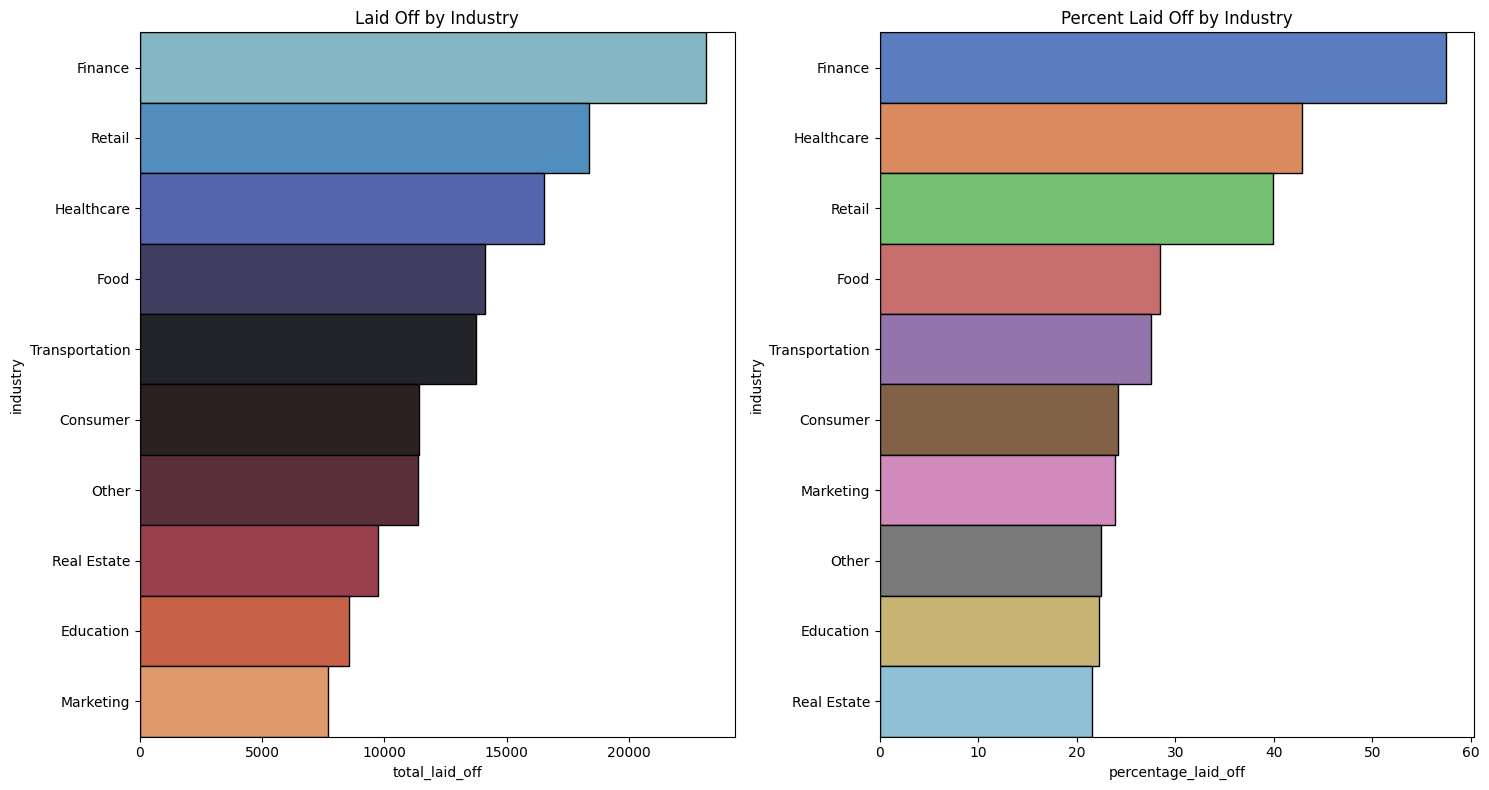

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(15,8))

ax[0] = sns.barplot(data=df4.groupby('industry')['total_laid_off'].sum().sort_values(ascending=False).reset_index().head(10),
            y='industry', x='total_laid_off', errorbar=None, width=1, edgecolor='black',dodge = True ,palette='icefire', ax=ax[0])
ax[0].set(title='Laid Off by Industry', xlabel='total_laid_off')

ax[1] = sns.barplot(data=df4.groupby('industry')['percentage_laid_off'].sum().sort_values(ascending=False).reset_index().head(10),
            y='industry', x='percentage_laid_off', errorbar=None, width=1, edgecolor='black', palette='muted', ax=ax[1])
ax[1].set(title='Percent Laid Off by Industry', xlabel='percentage_laid_off')

plt.tight_layout()
fig.show()

In [ ]:
#Countries having most Layoffs Count
world = df4.groupby("country")["total_laid_off"].sum().reset_index()
df4['country'].value_counts()

In [ ]:
figure = px.choropleth(world,locations="country",
                       locationmode = "country names", color="total_laid_off",
                       hover_name="country",range_color=[1,10000],
                       color_continuous_scale="reds",
                       title="Countries having LayOffs")
figure.show()

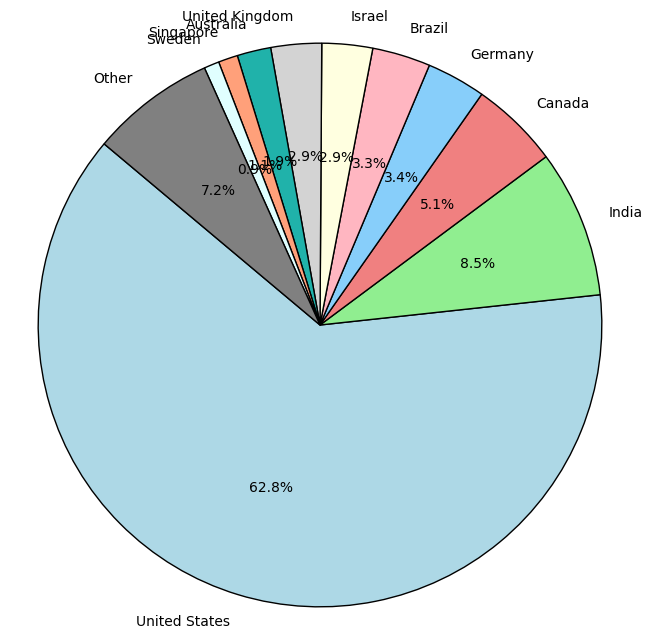

In [ ]:
# Calculate country distribution
country_distribution = df4['country'].value_counts()

# Select the top 10 countries and group the rest as "Other"
top_countries = country_distribution.head(10)  # Select the top 10 countries, you can adjust this number as needed
other_count = country_distribution.iloc[10:].sum()  # Calculate the sum of counts for other countries

# Combine the top countries and "Other"
country_data = pd.concat([top_countries, pd.Series(other_count, index=['Other'])])

# Define colors for the pie chart
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink', 'lightyellow', 'lightgrey', 'lightseagreen', 'lightsalmon', 'lightcyan','grey']  # Add more colors as needed

# Create the pie chart with top 10 countries and "Other" with borders
plt.figure(figsize=(8, 8))  # Set the figure size for better visibility
plt.pie(country_data, labels=country_data.index, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops=dict(edgecolor='black'))  # Add black borders to the pie chart slices
#plt.title('Geographical Distribution of Companies by Country', bbox={'facecolor': '0.8', 'pad': 0})  # Add a title with a colored background
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


In [377]:
import plotly.express as px
df4=df.copy()
df4.drop(columns=['date'], inplace=True)
us_df = df4[df4['country'] == 'India']
top_10 = us_df.groupby('location').sum().sort_values(by='percentage_laid_off',ascending=False).head(5).reset_index()

In [378]:
px.pie(top_10,names='location',values='total_laid_off',
      color_discrete_sequence=px.colors.sequential.Mint,
       title='Top 5 Locations in the India with the Highest Layoffs')

In [ ]:
sf_df = df4[df4['location'] == 'Bengaluru']
top_10 = sf_df.groupby('industry').sum().sort_values(by='percentage_laid_off',ascending=False).head(7).reset_index()

In [ ]:
custom_colors = ['#A8DADC', '#81E6D9', '#5EAAA8', '#9DCC9E', '#78BE82', '#AAD47D', '#B5E48C', '#DFF4D7', '#E1FAF9', '#CDF0EA']

fig = px.bar(
    top_10,
    x='industry',
    y='percentage_laid_off',
    text='percentage_laid_off',
    title='Top 7 Industries in the India, Bengaluru with the Highest Layoff Percentages',
    labels={'industry': 'Industry', 'percentage_laid_off': 'Percentage Laidoff'},
    color_discrete_sequence=custom_colors,
)

fig.update_traces(marker_line_width=0, opacity=0.7)

fig.update_layout(
    xaxis_title_font=dict(size=14, color='black'),
    yaxis_title_font=dict(size=14, color='black'),
    font=dict(size=12, color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_tickangle=0,
    xaxis_ticksuffix=" ",
    yaxis_ticksuffix="%",
)

fig.show()

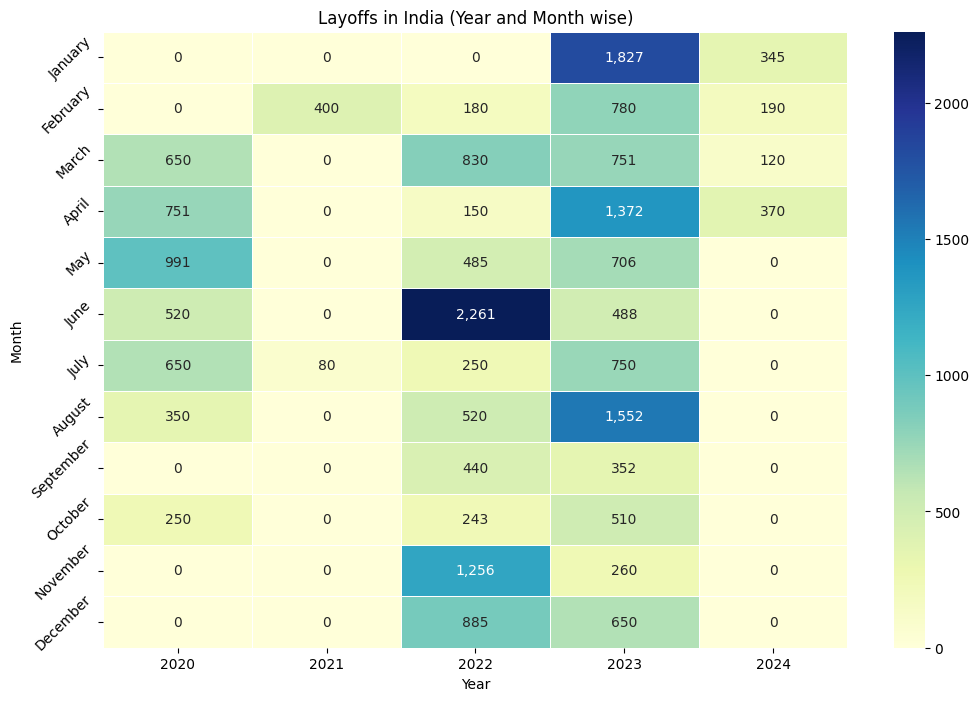

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named df
# Filter data for India
df_india = df[df['country'] == 'India']

# Convert 'date' column to datetime
df_india['date'] = pd.to_datetime(df_india['date'])

# Extract year and month from the date
df_india['Year'] = df_india['date'].dt.year
df_india['Month'] = df_india['date'].dt.month_name()

# Set the order of the months
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_india['Month'] = pd.Categorical(df_india['Month'], categories=months_order, ordered=True)

# Group by year and month and sum the total_laid_off
layoffs_by_month_year = df_india.groupby(['Year', 'Month'])['total_laid_off'].sum().reset_index()

# Pivot the data for visualization
layoffs_pivot = layoffs_by_month_year.pivot(index="Month", columns="Year", values="total_laid_off")

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(layoffs_pivot, cmap="YlGnBu", annot=True, fmt=",.0f", linewidths=.5)
plt.title("Layoffs in India (Year and Month wise)")
plt.xlabel("Year")
plt.ylabel("Month")
plt.yticks(rotation=45)
plt.show()


In [ ]:
from prophet import Prophet
import os
os

<module 'os' from '/usr/lib/python3.10/os.py'>

In [ ]:
total_laid_off_count = df1.groupby('date')['total_laid_off'].sum().reset_index()
total_laid_off_count

,date,total_laid_off
0,2020-03-11,75.00
1,2020-03-12,20.00
2,2020-03-13,14.00
3,2020-03-16,146.00
4,2020-03-18,4.00
...,...,...
655,2024-04-10,350.00
656,2024-04-11,280.00
657,2024-04-12,165.00
658,2024-04-16,12.00


In [ ]:
total_laid_off_count.columns=['ds','y']
total_laid_off_count ['ds']=pd.to_datetime(total_laid_off_count['ds'])

In [ ]:
sample_data = total_laid_off_count.tail(1000)
sample_data

,ds,y
0,2020-03-11,75.00
1,2020-03-12,20.00
2,2020-03-13,14.00
3,2020-03-16,146.00
4,2020-03-18,4.00
...,...,...
655,2024-04-10,350.00
656,2024-04-11,280.00
657,2024-04-12,165.00
658,2024-04-16,12.00


In [ ]:
m=Prophet(interval_width=0.95)
m.fit(sample_data)
future=m.make_future_dataframe(periods=24)
future.tail(420)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn93u5zoy/t044u0e3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn93u5zoy/3u4lmtwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46309', 'data', 'file=/tmp/tmpn93u5zoy/t044u0e3.json', 'init=/tmp/tmpn93u5zoy/3u4lmtwy.json', 'output', 'file=/tmp/tmpn93u5zoy/prophet_models0ajofv7/prophet_model-20240427125716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:57:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:57:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
264,2022-08-31
265,2022-09-01
266,2022-09-02
267,2022-09-06
268,2022-09-07
...,...
679,2024-05-08
680,2024-05-09
681,2024-05-10
682,2024-05-11


In [ ]:
forecast = m.predict(future)
forecast.tail(240)
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
679,2024-05-08,203.49,-280.74,680.75
680,2024-05-09,136.93,-355.69,628.91
681,2024-05-10,68.86,-480.32,605.44
682,2024-05-11,-77.91,-609.62,413.71
683,2024-05-12,-92.06,-566.95,386.39


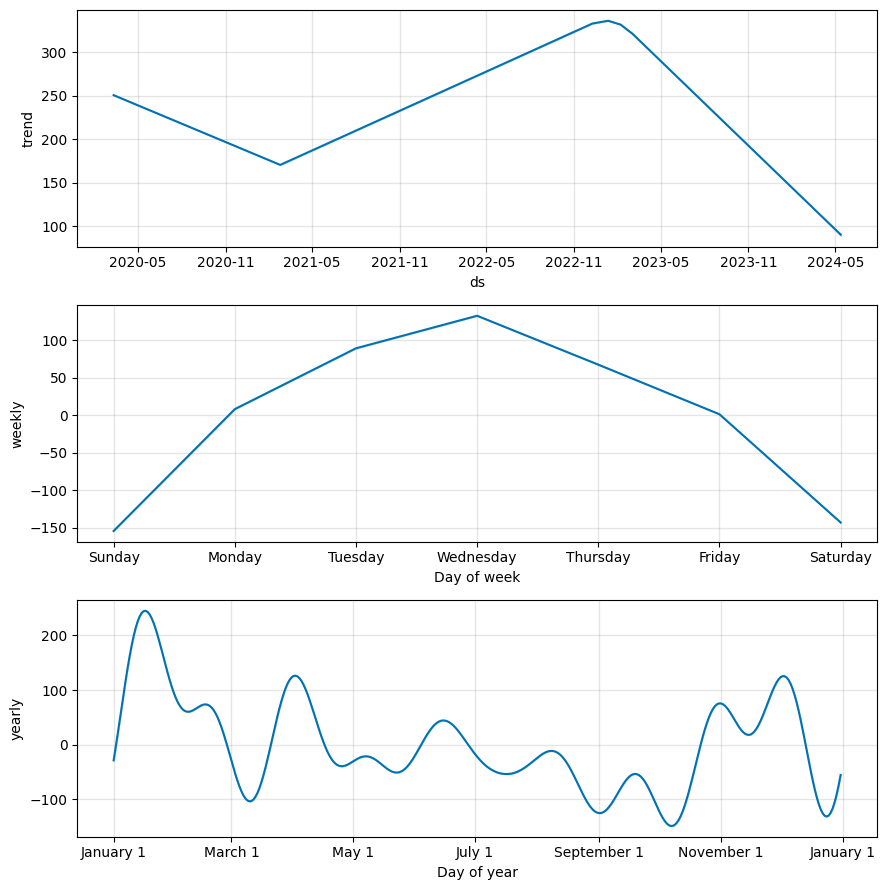

In [ ]:
confirmed_forecast_plot1 = m.plot_components(forecast)

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


# Drop the 'date' column if not needed
df2.drop(columns=['date'], inplace=True)

# Define features and target variable
features = ['company', 'location', 'industry', 'percentage_laid_off', 'stage', 'country', 'funds_raised', 'month', 'year']
target_variable = 'total_laid_off'

# Split data into features and target variable
X = df2[features]
y = df2[target_variable]

# Encode categorical variables if needed (e.g., using one-hot encoding)
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 5137.833160161353


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define features and target variable
features = ['company', 'location', 'industry', 'percentage_laid_off', 'stage', 'country', 'funds_raised', 'month', 'year']
target_variable = 'total_laid_off'

# Split data into features and target variable
X = df2[features]
y = df2[target_variable]

# Encode categorical variables if needed (e.g., using one-hot encoding)
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters as needed
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 4666.023045652174


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



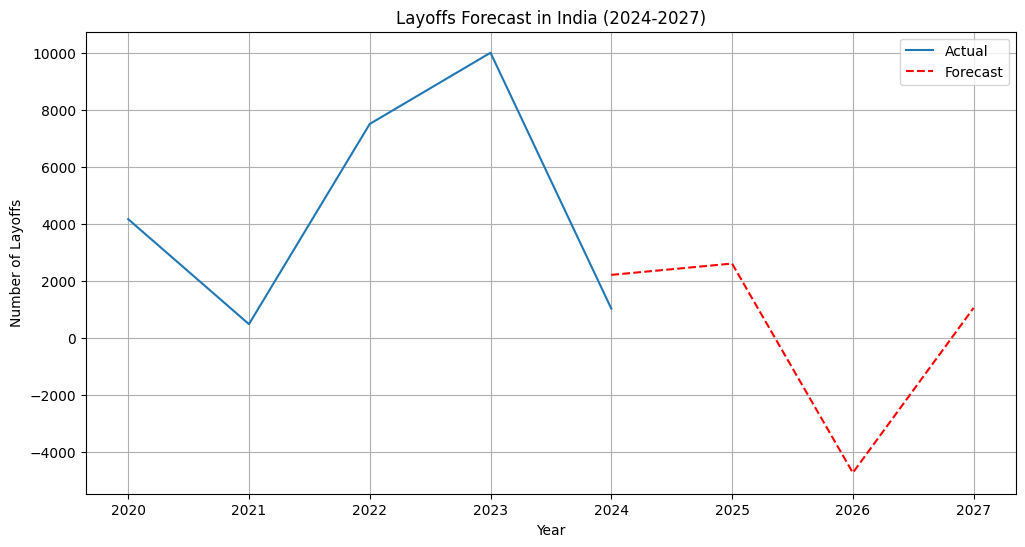

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have a DataFrame named df
# Filter data for India
df_india = df[df['country'] == 'India']

# Group by year and sum the total_laid_off
layoffs_by_year = df_india.groupby('year')['total_laid_off'].sum().reset_index()

# Set 'year' column as index
layoffs_by_year = layoffs_by_year.set_index('year')

# Fit ARIMA model
model = ARIMA(layoffs_by_year, order=(5,1,0)) # Example order, you may need to tune this
arima_result = model.fit()

# Forecast future layoffs for the next 4 years (2024, 2025, 2026, 2027)
future_years = np.arange(2024, 2028) # Change the range as needed
forecast = arima_result.forecast(steps=len(future_years))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(layoffs_by_year.index, layoffs_by_year['total_laid_off'], label='Actual')
plt.plot(future_years, forecast, color='red', linestyle='--', label='Forecast')
plt.title('Layoffs Forecast in India (2024-2027)')
plt.xlabel('Year')
plt.ylabel('Number of Layoffs')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



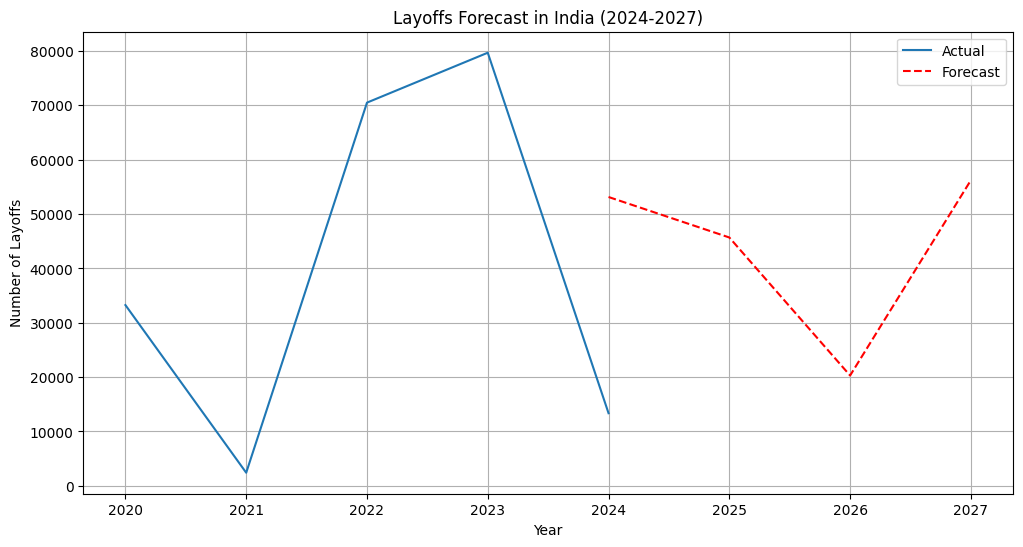

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA



# Group by year and sum the total_laid_off
layoffs_by_year = df.groupby('year')['total_laid_off'].sum().reset_index()

# Set 'year' column as index
layoffs_by_year = layoffs_by_year.set_index('year')

# Fit ARIMA model
model = ARIMA(layoffs_by_year, order=(5,1,0)) # Example order, you may need to tune this
arima_result = model.fit()

# Forecast future layoffs for the next 4 years (2024, 2025, 2026, 2027)
future_years = np.arange(2024, 2028) # Change the range as needed
forecast = arima_result.forecast(steps=len(future_years))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(layoffs_by_year.index, layoffs_by_year['total_laid_off'], label='Actual')
plt.plot(future_years, forecast, color='red', linestyle='--', label='Forecast')
plt.title('Layoffs Forecast in India (2024-2027)')
plt.xlabel('Year')
plt.ylabel('Number of Layoffs')
plt.legend()
plt.grid(True)
plt.show()
